# Model

In [2]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [3]:
# Accept input as numpy array

class GaussianMixtureModel():
    def __init__(self, n_components: int, n_iter: int, reg_covar= 1e-6, tol=1e-3, verbose=False):
        self.n_components = n_components
        self.n_iter = n_iter
        self.reg_covar = reg_covar
        self.tol = tol
        self.verbose = verbose
        self.pis_ = None # [K,]
        self.mus_ = None # [K, D]
        self.covs_ = None # [K, D, D]

    def _multivariate_gaussian(self, x, mu, cov): # TODO: rename the _multivariate_gaussian 
        N, D = x.shape
        diff = x - mu # [N, D]
        det_cov = np.linalg.det(cov) # []
        inv_cov = np.linalg.inv(cov) # [D, D]
        
        # Normalization constant
        norm_const = 1 / np.sqrt((2 * np.pi) ** D * det_cov) # []

        # Exponential term
        exp_term = np.exp(-0.5 * np.einsum('ni, ij, nj -> n', diff, inv_cov, diff)) # [N,]

        return norm_const * exp_term # [N,]

    def fit(self, X: NDArray[np.float64]):
        N, D = X.shape
        K = self.n_components

        # Initialization 
        pis = np.ones(K) / K # [K,]
        mus = X[np.random.choice(N, K, replace=False)] # [K, D]
        covs = np.array([np.eye(D) for _ in range(K)]) # [K, D, D]

        prev_ll = None

        for i in range(self.n_iter):
            # E-step
            resp = np.zeros([N, K]) # [N, K]
            for k in range(K):
                resp[:, k] = pis[k] * self._multivariate_gaussian(X, mus[k], covs[k])
            resp_sum = resp.sum(axis=1, keepdims=True) # [N, 1]
            resp /= resp_sum # [N, K]

            # M-step
            Nk = resp.sum(axis=0) # [K,]
            pis = Nk / N # [K,]
            mus = resp.T @ X / Nk[:, np.newaxis] # [K, D]
            for k in range(K):
                covs[k] = (resp[:, k][:, np.newaxis] * (X - mus[k])).T @ (X- mus[k]) / Nk[k]
                covs[k] += self.reg_covar * np.eye(D)
            
            # Log-likelihood
            ll = np.sum(np.log(resp_sum))
            if self.verbose:
                print(f"Iter {i} log-likelihood: {ll:.3f}")
            if prev_ll is not None and abs(prev_ll - ll) < self.tol:
                break
            prev_ll = ll
        self.pis_ = pis
        self.mus_ = mus
        self.covs_ = covs
        return self
    
    def _predict_proba(self, X):
        N, D = X.shape
        K = self.n_components

        resp = np.zeros([N, K]) # [N, K]
        for k in range(K):
            resp[:, k] = self.pis_[k] * self._multivariate_gaussian(X, self.mus_[k], self.covs_[k])
        resp_sum = resp.sum(axis=1, keepdims=True) # [N, 1]
        return resp / resp_sum # [N, K]
    
    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)


In [4]:
class GaussianMixtureRegression(GaussianMixtureModel):
    def __init__(self, n_components, n_iter, reg_covar= 1e-6, tol=1e-3, verbose=False):
        super().__init__(n_components, n_iter, reg_covar, tol, verbose)

    def fit(self, input_data, input_idx, output_idx): #TODO: X, Y ndim check, if not 2D, rasie error.
    # def fit(self, X, Y):    
        pi, mu, cov = self.pis_, self.mus_, self.covs_
        N = input_data.shape[0]
        K = pi.shape[0]
        n_out = len(output_idx)

        all_means = np.zeros([K, N, n_out])
        all_covs = np.zeros([K, n_out, n_out])
        weights = np.zeros((K, N))

        for k in range(K):
            mu_x = mu[k][input_idx]   # (Dx,)
            mu_y = mu[k][output_idx]  # (Dy,)
            cov_xx = cov[k][np.ix_(input_idx, input_idx)]      # (Dx, Dx)
            cov_xy = cov[k][np.ix_(input_idx, output_idx)]     # (Dx, Dy)
            cov_yx = cov[k][np.ix_(output_idx, input_idx)]     # (Dy, Dx)
            cov_yy = cov[k][np.ix_(output_idx, output_idx)]    # (Dy, Dy)
            inv_cov_xx = np.linalg.inv(cov_xx + 1e-10 * np.eye(len(input_idx)))  # Regularize

            all_covs[k] = cov_yy - cov_yx @ inv_cov_xx @ cov_xy

            diff_x = input_data - mu_x   # (N, Dx)
            # Compute conditional mean for each sample
            all_means[k] = mu_y + (cov_yx @ inv_cov_xx @ diff_x.T).T  # (N, Dy)

            weights[k] = pi[k] * self._multivariate_gaussian(input_data, mu_x, cov_xx) # (N,)

        # Normalize weights TODO:maybe move this to prdict?!
        weights_sum = np.sum(weights, axis=0, keepdims=True) + 1e-12
        weights = weights / weights_sum  # (K, N)
        weighted_pred = np.sum(weights[..., np.newaxis] * all_means, axis=0)  # (N, Dy)
        mode_idx = np.argmax(weights, axis=0)
        mode_pred = all_means[mode_idx, np.arange(N)]  # (N, Dy)
        
        # TODO: Put all follwoing return values to self.
        return mode_pred, weighted_pred, all_means, weights, all_covs
        
    def predict(self, input_data, input_idx, output_idx, method="mean"):
        mode_pred, weights_pred, _, _, _ = self.fit(input_data, input_idx, output_idx) # Change the position of fit.
        if method == "mean":
            return weights_pred
        elif method == "mode":
            return mode_pred
        else:
            raise ValueError("method must be either 'mean' or 'mode'")
    

    def predict_logpdf(self, input_data, output_data, input_idx, output_idx):
        """
        Returns: (N,) logpdf values under the GMR conditional mixture
        """
        N = input_data.shape[0]
        _, _, all_means, weights, all_covs = self._full_mixture(input_data, input_idx, output_idx)
        logpdfs = np.zeros(N) # [N,]
        for i in range(N):
            y = output_data[i]
            comps = []
            for k in range(weights.shape[0]):
                mean = all_means[k, i]
                cov = all_covs[k]
                # Log-pdf of y under component k
                det_cov = np.linalg.det(cov)
                inv_cov = np.linalg.inv(cov)
                norm_const = 1 / np.sqrt((2 * np.pi) ** len(y) * det_cov)
                diff = y - mean
                exp_term = np.exp(-0.5 * diff @ inv_cov @ diff)
                log_pdf = np.log(norm_const * exp_term + 1e-300)  # Prevent log(0)
                comps.append(np.log(weights[k, i] + 1e-12) + log_pdf)
            logpdfs[i] = logsumexp_np(comps)
        return logpdfs

    def sample(self, input_data, input_idx, output_idx, n_samples=1, random_state=None):
        """
        Sample output(s) given input(s) using the GMR conditional mixture.
        input_data: (N, len(input_idx))
        Returns: samples (N, n_samples, len(output_idx))
        """
        if random_state is not None:
            np.random.seed(random_state)
        N = input_data.shape[0]
        _, _, all_means, weights, all_covs = self.full_mixture(input_data, input_idx, output_idx)
        K = weights.shape[0]
        n_out = len(output_idx)
        samples = np.zeros((N, n_samples, n_out))
        for i in range(N):
            # For each sample, sample n_samples from the conditional mixture
            # First, select which component (using mixture weights)
            comp_choices = np.random.choice(K, size=n_samples, p=weights[:, i])
            for j, k in enumerate(comp_choices):
                # Draw from the conditional Gaussian
                samples[i, j] = np.random.multivariate_normal(all_means[k, i], all_covs[k])
        return samples
    
def logsumexp_np(arr):
        arr = np.array(arr)
        maxa = np.max(arr)
        return maxa + np.log(np.sum(np.exp(arr - maxa)))

# Test

In [38]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/mlinsights/freemium/main/datasets/regression-analysis/1d_nonlinear_regression_data.csv')
X = df.iloc[:, 0].values.reshape(-1, 1)
Y = df.iloc[:, 1].values.reshape(-1, 1)

# X = np.linspace(-3, 3, 200).reshape(-1, 1)
# Y = 0.5 * X + np.sin(X) + 0.2 * np.random.randn(*X.shape)

Z = np.concatenate([X, Y], axis=1)  

Text(0, 0.5, 'Y')

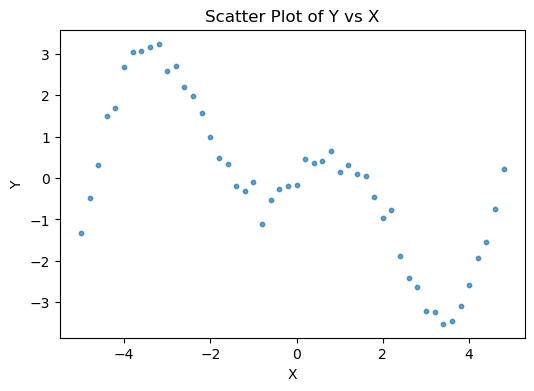

In [39]:
plt.figure(figsize=(6, 4))
plt.scatter(X, Y, s=10, alpha=0.7)
plt.title('Scatter Plot of Y vs X')
plt.xlabel('X')
plt.ylabel('Y')

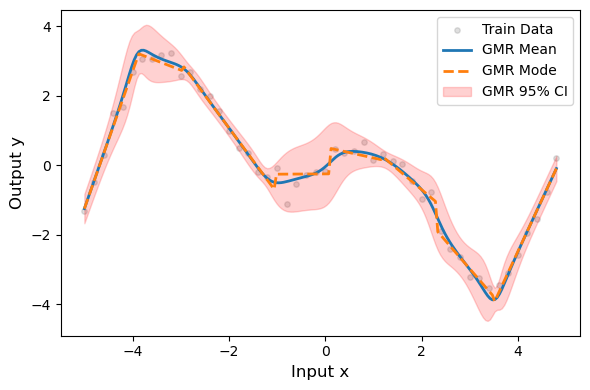

In [75]:
gmr = GaussianMixtureRegression(n_components=8, n_iter=400)
gmr.fit(Z)

# ======= Query grid =======
x_query = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)  # (200, 1)

# ======= GMR predictions =======
mode_pred, mean_pred, all_means, weights, all_covs = gmr.full_mixture(x_query, input_idx=[0], output_idx=[1])
# all shapes:
# mode_pred: (200, 1)
# mean_pred: (200, 1)
# all_means: (K, 200, 1)
# weights: (K, 200)
# all_covs: (K, 1, 1)

# ======= Uncertainty computation =======
# Flatten to 1D if output is scalar
mean_pred_1d = mean_pred[:, 0]
mode_pred_1d = mode_pred[:, 0]
all_means_1d = all_means[:, :, 0]  # (K, N)
all_vars_1d = np.array([cov[0, 0] for cov in all_covs])  # (K,)

# Predictive variance at each x (GMM formula)
weighted_vars = np.sum(weights * all_vars_1d[:, None], axis=0)  # (N,)
mean_sq = np.sum(weights * all_means_1d**2, axis=0)  # (N,)
sq_mean = mean_pred_1d**2  # (N,)
total_var = weighted_vars + (mean_sq - sq_mean)  # (N,)
std = np.sqrt(total_var)  # (N,)

plt.figure(figsize=(6, 4))
plt.scatter(X, Y, s=15, alpha=0.25, label="Train Data", color="gray", zorder=1)
plt.plot(x_query, mean_pred_1d, color="C0", label="GMR Mean", linewidth=2, zorder=3)
plt.plot(x_query, mode_pred_1d, color="C1", linestyle="--", label="GMR Mode", linewidth=2, zorder=4)
plt.fill_between(
    x_query.flatten(),
    mean_pred_1d - 2 * std,
    mean_pred_1d + 2 * std,
    color="red",
    alpha=0.18,
    label="GMR 95% CI",
    zorder=2
)

plt.xlabel("Input x", fontsize=12)
plt.ylabel("Output y", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


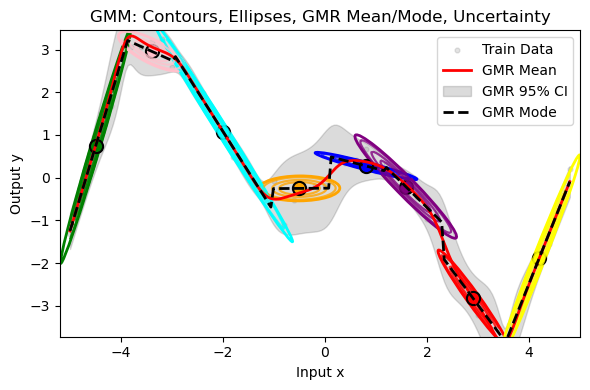

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_cov_ellipse(mean, cov, ax, n_std=2.0, edgecolor='black', **kwargs):
    """Plot an ellipse representing the covariance matrix."""
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta,
                      edgecolor=edgecolor, facecolor='None', lw=2, **kwargs)
    ax.add_patch(ellipse)


# Set up grid for density contours
x_grid = np.linspace(X.min(), X.max(), 200)
y_grid = np.linspace(Y.min(), Y.max(), 200)
Xg, Yg = np.meshgrid(x_grid, y_grid)
pos = np.dstack((Xg, Yg))

fig, ax = plt.subplots(figsize=(6, 4))
colors = ['r', 'g', 'b', 'orange', 'purple', 'cyan', 'yellow', 'pink']

# 1. Training data
ax.scatter(X, Y, s=12, alpha=0.22, label='Train Data', color='gray', zorder=1)

# 2. GMR mean prediction + uncertainty band
ax.plot(x_query, mean_pred[:,0], color='red', lw=2, label='GMR Mean', zorder=20)
ax.fill_between(
    x_query.flatten(),
    mean_pred[:,0] - 2*std,
    mean_pred[:,0] + 2*std,
    color="k", alpha=0.14, label="GMR 95% CI", zorder=0
)

# 3. GMR mode prediction
ax.plot(x_query, mode_pred[:,0], color='k', lw=2, linestyle='--', label='GMR Mode', zorder=21)

# 4. GMM components: ellipses, means, and contours
K = gmr.n_components
for k in range(K):
    mean = gmr.mus_[k]
    cov = gmr.covs_[k]
    color = colors[k % len(colors)]
    # Avoid degenerate/singular components
    det = np.linalg.det(cov)
    if det < 1e-6 or np.isnan(det) or np.isinf(det):
        print(f"Skip cluster {k}: suspicious covariance.")
        continue
    
    # Contour
    try:
        # rv = multivariate_normal(mean, cov)
        # pdf = rv.pdf(pos)
        xy_flat = pos.reshape(-1, 2)
        pdf_flat = gmr._multivariate_gaussian(xy_flat, mean, cov)
        pdf = pdf_flat.reshape(Xg.shape)
        levels = [0.2 * pdf.max(), 0.4 * pdf.max(), 0.6 * pdf.max()]

        ax.contour(
            Xg, Yg, pdf, 
            levels=levels, colors=[color], linewidths=1.6, alpha=0.80, zorder=2+k
        )
    except Exception as e:
        print(f"Could not plot contour for component {k}: {e}")
        continue
    
    # Ellipse (2 std)
    plot_cov_ellipse(mean, cov, ax, n_std=2, edgecolor=color)
    # Mean marker
    ax.scatter(*mean, color=color, s=90, marker='o', edgecolor='k', lw=1.5, zorder=5)

ax.set_xlabel('Input x')
ax.set_ylabel('Output y')
ax.set_xlim(X.min()-0.2, X.max()+0.2)
ax.set_ylim(Y.min()-0.2, Y.max()+0.2)
ax.set_title('GMM: Contours, Ellipses, GMR Mean/Mode, Uncertainty')
ax.legend()
plt.tight_layout()
plt.show()
